### **PRESENTACIÓN APRENDIZAJE AUTOMATICO**

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from imblearn.over_sampling import SMOTE
from itertools import combinations

# DATASETS
df1 = pd.read_csv('/content/train.csv')
df2 = pd.read_csv('/content/test.csv')
target_exp = pd.read_csv('/content/submission.csv')
df = pd.concat([df1, df2], ignore_index = True)       # Concatenacion de datasets

#df

## **LIMPIEZA DE DATOS**

In [3]:
filas_duplicadas = df.duplicated().sum()
#print(f"La cantidad de filas duplicadas es: {filas_duplicadas}")

nan_counts = df.isna().sum()
#print(f"La cantidad de filas duplicadas es: {nan_counts}")

df = df.drop_duplicates()                             # Eliminacion de duplicados
df = df.dropna(subset=['Class'])                        # Sacar NaN de Class
df = df.dropna(subset=['Popularity'])             # Sacar NaN de Popularity
df = df.dropna(subset=['instrumentalness'])       # Sacar NaN de instrumentalness

clases = ['Folk Acústico', 'Música Alternativa', 'Blues', 'Bollywood', 'Country', 'Hip-Hop', 'Indie Alternativo', 'Instrumental', 'Metal', 'Pop', 'Rock']

df['Rock'] = df['Class'].apply(lambda x: True if x == 10 else False)

df['ClassName'] = df['Class'].apply(lambda x: clases[int(x)])  #Le agrego los nombres

conteo_clases = df['ClassName'].value_counts()       # Cantidad de clases que hay en el df
#print(conteo_clases)

## **EXPLORACIÓN DE LOS DATOS**

**Boxplot por clase**

In [ ]:
# EXPLORANDO DATASET

grouped = df.groupby("Class")

dataframes = [group for _, group in grouped]

plt.figure(figsize=(10, 6))
plt.boxplot([df["liveness"] for df in dataframes], labels=[name for name, _ in grouped])
plt.xlabel("Class")
plt.ylabel("liveness")
plt.title("Boxplot por Clase")
plt.show()

**Graficos por atributo**

In [ ]:
# GRAFICOS Relacione entre atributos

# Ver si podemos encontrar generos que sean parecidos en sus atributos y fusionarlos

colores = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'magenta', 'black']

#Todas las combinaciones de las variables

combinaciones = [
    ('Popularity', 'danceability'),
    ('Popularity', 'energy'),
    ('Popularity', 'loudness'),
    ('Popularity', 'speechiness'),
    ('Popularity', 'acousticness'),
    ('Popularity', 'instrumentalness'),
    ('Popularity', 'valence'),
    ('danceability', 'energy'),
    ('danceability', 'loudness'),
    ('danceability', 'speechiness'),
    ('danceability', 'acousticness'),
    ('danceability', 'instrumentalness'),
    ('danceability', 'valence'),
    ('energy', 'loudness'),
    ('energy', 'speechiness'),
    ('energy', 'acousticness'),
    ('energy', 'instrumentalness'),
    ('energy', 'valence'),
    ('loudness', 'speechiness'),
    ('loudness', 'acousticness'),
    ('loudness', 'instrumentalness'),
    ('loudness', 'valence'),
    ('speechiness', 'acousticness'),
    ('speechiness', 'instrumentalness'),
    ('speechiness', 'valence'),
    ('acousticness', 'instrumentalness'),
    ('acousticness', 'valence'),
    ('instrumentalness', 'valence')
]
for comb in combinaciones:
  print(comb)
  for df in dataframes:

      x_clase = df[comb[0]].apply(float)
      y_clase = df[comb[1]].apply(float)
      color = colores[int(df['Class'].loc[df.index[0]])]

      clase_str = str(df['Class'].loc[df.index[0]])
      plt.title(clase_str)
      plt.scatter(x_clase, y_clase, c=color, label='Clase ' + clase_str)
      plt.legend()
      plt.show()

**Matriz de correlacion entre atributos por clase**

In [ ]:
#Otra forma de ver como se relacionan las variables entre si por clases

classes = df['Class'].unique()

plt.figure(figsize=(70, 55))

for i, class_label in enumerate(classes):
    class_df = df[df['Class'] == class_label]
    correlation_matrix = class_df.corr()
    plt.subplot(3, 4, i+1, aspect='equal', adjustable='box')
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix - Class {class_label}')

plt.tight_layout()
plt.show()

**Grafico de barras por clase**

In [ ]:
#Cantidad de entradas en cada clase, lo usamos para ver el desbalance de clases

unique_classes, counts = np.unique(df[['ClassName']], return_counts=True)

sorted_indices = np.argsort(counts)[::-1]
sorted_classes = unique_classes[sorted_indices]
sorted_counts = counts[sorted_indices]

plt.figure(figsize=(10, 8))

plt.bar(sorted_classes, sorted_counts, align='center', alpha=0.7, color='#006400')

plt.xlabel('Clase')
plt.ylabel('Cantidad de Entradas')
plt.title('Cantidad de Entradas por Clase')
plt.xticks(rotation=60)

plt.show()

**ATRIBUTOS A USAR**

Artributos elegidos por criterio intuitivo y estadistico anteriormente visto.

In [5]:
X = df[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
y = df[['ClassName']]

## **RANDOM FOREST**

Modelo elegido debido a la gran cantidad de datos y para lograr una mejor clasificación de los generos musicales.

**TRAIN**

In [6]:
# Modelo RFC con Validacion Cruzada, (SIN SMOTE)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

# RFC, FITEO, VALIDACION CRUZADA

RFC = RandomForestClassifier(random_state = 42, n_jobs=-1)
RFC.fit(X_train, y_train)
cv_results = cross_validate(RFC, X_train , y_train, scoring = "accuracy", n_jobs = -1, return_estimator = True)

# Promedio de los accuracy en cada fold de la Validacion Cruzada del modelo de RFC

<ipython-input-6-bc5fac1b2c2b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(X_train, y_train)


In [ ]:
cv_results

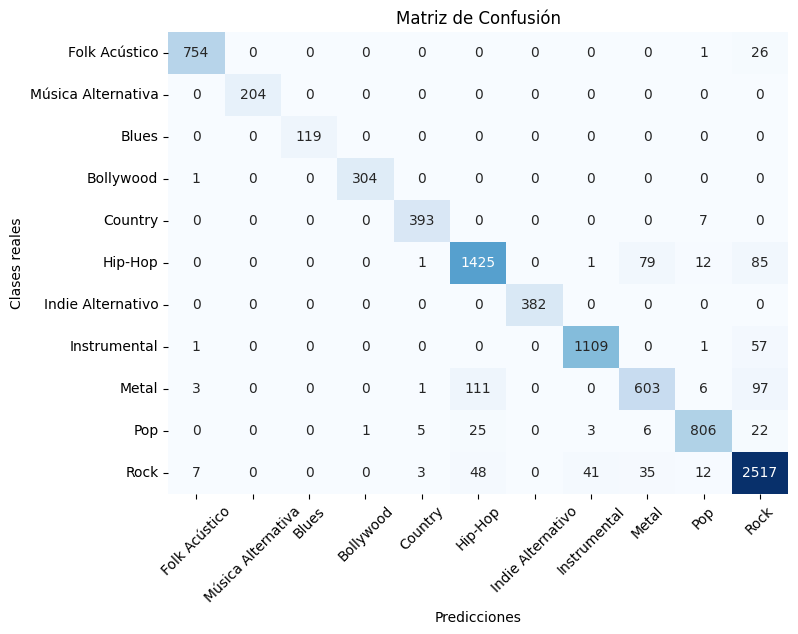

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Score: 0.4180810895423514
Accuracy: 0.9250590508911316
                    precision    recall  f1-score   support

             Blues       0.98      0.97      0.97       781
         Bollywood       1.00      1.00      1.00       204
           Country       1.00      1.00      1.00       119
     Folk Acústico       1.00      1.00      1.00       305
           Hip-Hop       0.98      0.98      0.98       400
 Indie Alternativo       0.89      0.89      0.89      1603
      Instrumental       1.00      1.00      1.00       382
             Metal       0.96      0.95      0.96      1168
Música Alternativa       0.83      0.73      0.78       821
               Pop       0.95      0.93      0.94       868
              Rock       0.90      0.95      0.92      2663

          accuracy                           0.93      9314
         macro avg       0.95      0.94      0.95      9314
      weighted avg       0.92      0.93      0.92      9314



In [7]:
#TRAIN#

# Matriz de confusion
conf_matrix = confusion_matrix(y_train, RFC.predict(X_train))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases, yticklabels = clases)

plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

plt.title("Matriz de Confusión")
plt.show()

#Validacion Cruzada
scores = cross_val_score(RFC, X_train, y_train, scoring = "accuracy")
print('Score:', scores.mean())

# Accuracy
accuracy = accuracy_score(y_train, RFC.predict(X_train))
print("Accuracy:", accuracy)

# Reporte de clasificación
print(classification_report(y_train,RFC.predict(X_train)))

**TEST**

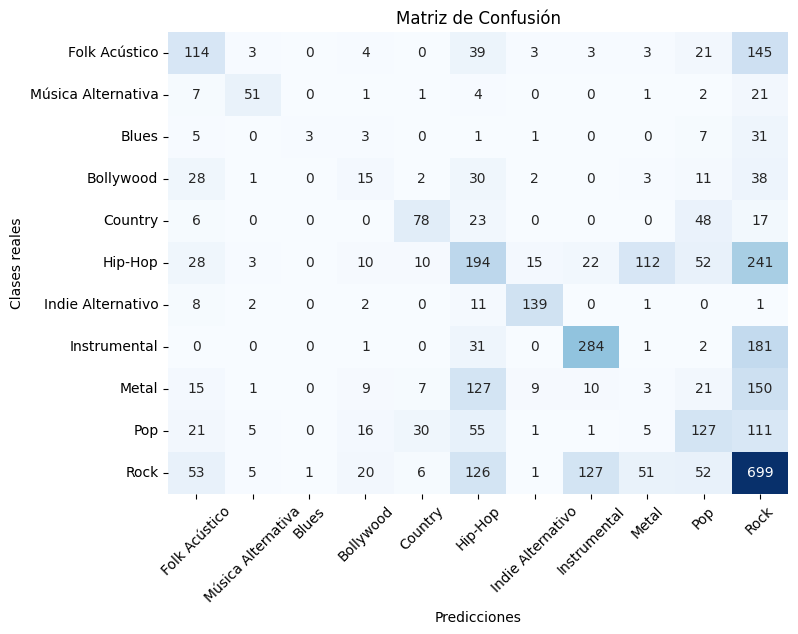

Accuracy: 0.4276052104208417
                    precision    recall  f1-score   support

             Blues       0.40      0.34      0.37       335
         Bollywood       0.72      0.58      0.64        88
           Country       0.75      0.06      0.11        51
     Folk Acústico       0.19      0.12      0.14       130
           Hip-Hop       0.58      0.45      0.51       172
 Indie Alternativo       0.30      0.28      0.29       687
      Instrumental       0.81      0.85      0.83       164
             Metal       0.64      0.57      0.60       500
Música Alternativa       0.02      0.01      0.01       352
               Pop       0.37      0.34      0.36       372
              Rock       0.43      0.61      0.50      1141

          accuracy                           0.43      3992
         macro avg       0.47      0.38      0.40      3992
      weighted avg       0.41      0.43      0.41      3992



In [8]:
#TEST#

# Matriz de confusion
conf_matrix = confusion_matrix(y_test, RFC.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases, yticklabels = clases)

plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

plt.title("Matriz de Confusión")
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, RFC.predict(X_test))
print("Accuracy:", accuracy)

# Reporte de clasificación
print(classification_report(y_test,RFC.predict(X_test)))

## **CLASS WEIGHT**

In [ ]:
 # Class Weight

from sklearn.model_selection import train_test_split
import random

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

random.seed(42)

# Probamos asignando pesos
class_weights = {'Blues': 6, 'Bollywood': 2, 'Country': 2, 'Folk Acústico':6, 'Hip-Hop':1, 'Indie Alternativo':4, 'Instrumental':1, 'Metal':4, 'Música Alternativa':2, 'Pop':2, 'Rock': 0.01}

RFC = RandomForestClassifier(class_weight = class_weights)

score = cross_val_score(RFC, X_train, y_train, scoring = "accuracy")

RFC.fit(X_train, y_train)

accuracy = accuracy_score(y_test, RFC.predict(X_test))

print('Train: ', score.mean())
print('Test: ', accuracy)
print(classification_report(y_test,RFC.predict(X_test)))

## **RANDOM FOREST CON SMOTE**

Utilizamos SMOTE para lograr un equilibrio mejor de los datos, ya que  tenemos un desbalance en la cantidad de canciones para cada genero, logrando una mejor clasificación

**TRAIN**

In [ ]:
# SMOTE
random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# RFC con SMOTE
RFC = RandomForestClassifier(random_state = 42, n_jobs=-1)
RFC.fit(X_resampled, y_resampled)

# Validacion Cruzada en los datos de RFC con SMOTE
cv_results = cross_validate(RFC, X_resampled, y_resampled, scoring = "accuracy", n_jobs = -1, return_estimator = True)

# Promedio de los accuracy en cada fold de la Validacion Cruzada del modelo de RFC con SMOTE
scores = cross_val_score(RFC, X_resampled, y_resampled, scoring = "accuracy")
print('Score:', scores.mean())

# conteo_clases = y_resampled['Class'].value_counts()       # Cantidad de clases que hay en el df con SMOTE

In [ ]:
cv_results

In [ ]:
# Accuracys, recall, f1-score del modelo RFC con SMOTE

# scores = cross_val_predict(RFC, X_resampled, y_resampled, n_jobs=-1, method = 'predict')          # DE QUE NOS SIRVE?
# print('Score:', scores.mean())

conf_matrix = confusion_matrix(y_resampled, RFC.predict(X_resampled))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases, yticklabels = clases)

# Agrega etiquetas a los ejes.
plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

# Agrega títulos y muestra el gráfico.
plt.title("Matriz de Confusión")
plt.show()


#TRAIN
accuracy = accuracy_score(y_resampled, RFC.predict(X_resampled))
print("Accuracy en Train:", accuracy)

# Mostrar el reporte de clasificación
print(classification_report(y_resampled, RFC.predict(X_resampled)))



**TEST**

In [ ]:
# Matriz sobre los conjuntos resampled de SMOTE

conf_matrix = confusion_matrix(y_test, RFC.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases, yticklabels = clases)

plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

plt.title("Matriz de Confusión")
plt.show()

#TEST
accuracy = accuracy_score(y_test, RFC.predict(X_test))
print("Accuracy en Test:", accuracy)

# Reporte de clasificación
print(classification_report(y_test, RFC.predict(X_test)))

## **SEPARANDO ROCK**

¿Que pasa con ROCK?
Vemos que muchas canciones son clasificacdas como ROCK aunque no lo sean.
LO podemos ver en la matriz vemos que muchas canciones que NO son ROCK son predichas como tal, aprox. 892 canciones.
Este es el problema mas grande.



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

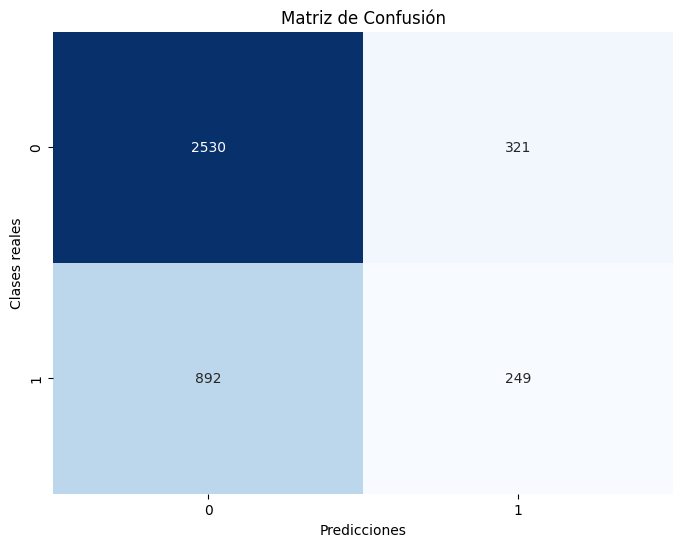

{'fit_time': array([1.20750737, 1.30913663, 1.70076728, 1.19425797, 1.20394659]), 'score_time': array([0.04980159, 0.0581727 , 0.04999566, 0.04937887, 0.04875922]), 'test_score': array([0.69511541, 0.68813741, 0.6747182 , 0.68384326, 0.68689581])}
0.6857420178004247
              precision    recall  f1-score   support

       False       0.74      0.89      0.81      2851
        True       0.44      0.22      0.29      1141

    accuracy                           0.70      3992
   macro avg       0.59      0.55      0.55      3992
weighted avg       0.65      0.70      0.66      3992



,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class,Rock,ClassName
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10.0,True,Rock
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6.0,False,Indie Alternativo
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10.0,True,Rock
5,The Stooges,Search and Destroy - Iggy Pop Mix,53.0,0.235,0.977,6.0,0.878,1,0.1070,0.003530,0.006040,0.1720,0.2410,152.952,208133.0,4,6.0,False,Indie Alternativo
6,Solomon Burke,None Of Us Are Free,48.0,0.674,0.658,5.0,-9.647,0,0.1040,0.404000,0.000001,0.0981,0.6770,143.292,329387.0,4,2.0,False,Blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,Green-House,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6.0,False,Indie Alternativo
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2.0,False,Blues
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8.0,False,Metal
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8.0,False,Metal


In [4]:
random.seed(42)

# CONJUNTO DE DATOS ROCK
X = df[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
y = df[['Rock']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

# RFC de ROCK O NO
RFC = RandomForestClassifier(random_state = 42, n_jobs=-1)

# Validacion Cruzada de ROCK O NO
cv_results = cross_validate(RFC, X_train, y_train, scoring = "accuracy")

score = cross_val_score(RFC, X_train, y_train, n_jobs=-1)

# FIT
RFC.fit(X_train, y_train)

# Matriz de los datos
conf_matrix = confusion_matrix(y_test, RFC.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Agrega etiquetas a los ejes.
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

# Agrega títulos y muestra el gráfico.
plt.title("Matriz de Confusión")
plt.show()

print(cv_results)
print(score.mean())

# Reporte de Clasificacion
print(classification_report(y_test, RFC.predict(X_test)))
df

**DATOS SIN ROCK**

Experimentamos sacar el genero ROCK, ya que muchas de las canciones de otros generos son clasficados como ROCK, y pensamos que sacando este genero nos puede dar una mejor vision de este problema y logra clasificar correctamente todas las canciones, o si tambien son trasladadas/clasificadas mayormente en otro genero.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

{'fit_time': array([1.00869393, 1.00742531, 1.03408408, 1.04984474, 1.39300466]), 'score_time': array([0.04966712, 0.05056262, 0.05056596, 0.05060697, 0.07203197]), 'test_score': array([0.47633358, 0.47443609, 0.47368421, 0.48120301, 0.48796992])}
Score: 0.4787253633708614


<ipython-input-11-923459844236>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(X_train, y_train)


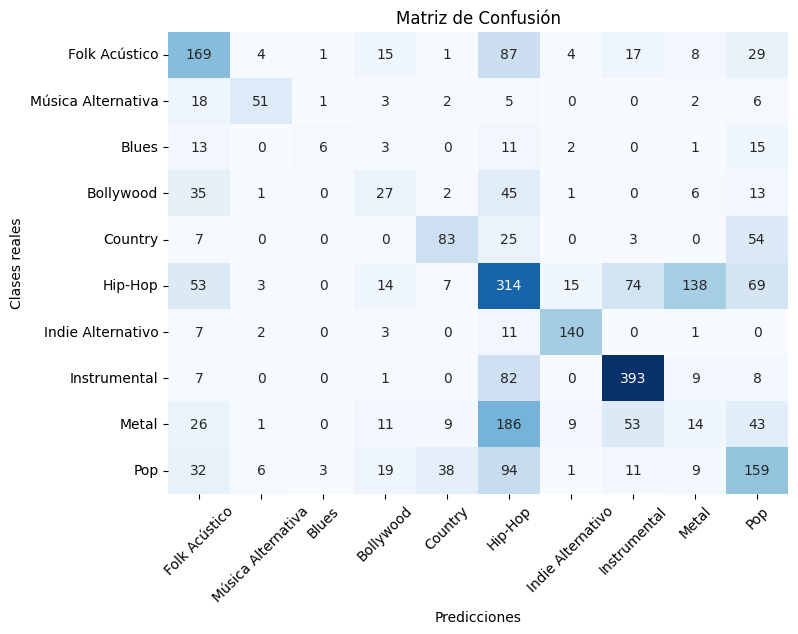

                    precision    recall  f1-score   support

             Blues       0.46      0.50      0.48       335
         Bollywood       0.75      0.58      0.65        88
           Country       0.55      0.12      0.19        51
     Folk Acústico       0.28      0.21      0.24       130
           Hip-Hop       0.58      0.48      0.53       172
 Indie Alternativo       0.37      0.46      0.41       687
      Instrumental       0.81      0.85      0.83       164
             Metal       0.71      0.79      0.75       500
Música Alternativa       0.07      0.04      0.05       352
               Pop       0.40      0.43      0.41       372

          accuracy                           0.48      2851
         macro avg       0.50      0.45      0.45      2851
      weighted avg       0.46      0.48      0.46      2851



In [11]:
# CONJUNTO DE DATOS SIN ROCK

random.seed(42)

# DATOS SIN ROCK
df2 = df.loc[df['Rock'] == False]

clases1 = ['Folk Acústico', 'Música Alternativa', 'Blues', 'Bollywood', 'Country', 'Hip-Hop', 'Indie Alternativo', 'Instrumental', 'Metal', 'Pop']

X = df2[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
y = df2[['ClassName']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

# RFC DE SIN ROCK
RFC = RandomForestClassifier(random_state = 42, n_jobs=-1)

# VALIDACION CRUZADA DE SIN ROCK
scores = cross_val_score(RFC, X_train, y_train, scoring = "accuracy", n_jobs=-1)
cv_results = cross_validate(RFC, X_train, y_train, scoring = "accuracy")
print(cv_results)
print('Score:', scores.mean())

# FIT
RFC.fit(X_train, y_train)

# Matriz DE SIN ROCK
conf_matrix = confusion_matrix(y_test, RFC.predict(X_test))
#conf_matrix = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases1, yticklabels = clases1)

# Agrega etiquetas a los ejes.
plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

# Agrega títulos y muestra el gráfico.
plt.title("Matriz de Confusión")
plt.show()

# Reporte de Clasificacion
print(classification_report(y_test, RFC.predict(X_test)))

**SIN ROCK CON SMOTE**

Probamos el modelo con SMOTE.
Logramos ver que en ambos modelos sin el genero ROCK, los accuracys aumentan y vemos como en la matriz son mas precisas a la hora de predecir el genero de las canciones.

<ipython-input-13-9f81724605f8>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(X_resampled, y_resampled)


Score: 0.7547099189020586
{'fit_time': array([1.00869393, 1.00742531, 1.03408408, 1.04984474, 1.39300466]), 'score_time': array([0.04966712, 0.05056262, 0.05056596, 0.05060697, 0.07203197]), 'test_score': array([0.47633358, 0.47443609, 0.47368421, 0.48120301, 0.48796992])}


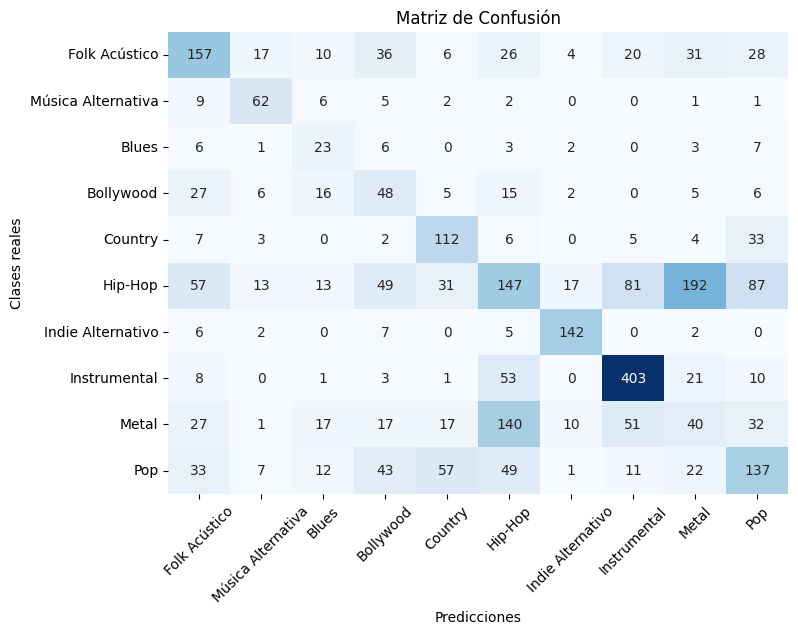

                    precision    recall  f1-score   support

             Blues       0.47      0.47      0.47       335
         Bollywood       0.55      0.70      0.62        88
           Country       0.23      0.45      0.31        51
     Folk Acústico       0.22      0.37      0.28       130
           Hip-Hop       0.48      0.65      0.56       172
 Indie Alternativo       0.33      0.21      0.26       687
      Instrumental       0.80      0.87      0.83       164
             Metal       0.71      0.81      0.75       500
Música Alternativa       0.12      0.11      0.12       352
               Pop       0.40      0.37      0.38       372

          accuracy                           0.45      2851
         macro avg       0.43      0.50      0.46      2851
      weighted avg       0.43      0.45      0.43      2851



In [13]:
# AHORA VER EL SMOTE EN EL CONJUNTO DE DATOS DE SIN ROCK

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# RFC con SMOTE
RFC = RandomForestClassifier(random_state = 42, n_jobs=-1)
RFC.fit(X_resampled, y_resampled)

# Validacion Cruzada en los datos de RFC con SMOTE
cross_validate(RFC, X_resampled, y_resampled, scoring = "accuracy", n_jobs = -1, return_estimator = True)
scores = cross_val_score(RFC, X_resampled, y_resampled, scoring = "accuracy", n_jobs=-1)

print('Score:', scores.mean())
print(cv_results)

# Matriz DE SIN ROCK
conf_matrix = confusion_matrix(y_test, RFC.predict(X_test))
#conf_matrix = confusion_matrix(y_train, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = clases1, yticklabels = clases1)

# Agrega etiquetas a los ejes.
plt.xticks(rotation = 45)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")

# Agrega títulos y muestra el gráfico.
plt.title("Matriz de Confusión")
plt.show()




# Reporte de Clasificacion
print(classification_report(y_test, RFC.predict(X_test)))

# EL PROMEDIO DE ACC BAJA UN 0.07, Y EL RECALL AUMENTA UN 0.07 CON RESPECTO AL MODELO SIN SMOTE
# EL SMOTE NO TERMINA SIENDO SIGNIFICATIVO

## **CURVA ROC EN EL MODELO RANDOM FOREST**

In [ ]:
## CURVA ROC ##

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

X = df[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
y = df[['Class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, stratify=y)

RFC = OneVsRestClassifier(RandomForestClassifier(random_state = 42, n_jobs=-1))
RFC.fit(X_train, y_train)
#RFC.fit(X_resampled, y_resampled)

y_pred = RFC.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=list(range(11)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(11):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black'])

plt.figure(figsize=(8, 6))

for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], label=f'{clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()

## **CONCLUSIONES**

Se logró una predicción decente para la cantidad de clases que había.

Hay géneros musicales que son más variantes que otros, y por lo tanto menos clasificables.

Faltan variables o datos para ayudar al modelo a separar las clases cuyas diferencias no son tan evidentes en el dataset actual .

## ** ASPECTOS A MEJORAR Y AGREGAR**

Variables musicales nuevas.
  Instrumentos utilizados
  Temática de la canción
  Fecha de lanzamiento
  Discográfica / Productor
  Disco al que pertenecen

Un conjunto de datos más balanceado con una cantidad de canciones similares por género.

Un dataset más amplio que tenga la intención de incluir todos los géneros musicales, en lugar del actual que está basado únicamente en popularidad.

